<img src="../Fink_PrimaryLogo_WEB.jpg" width=400 />

# Fink case study: ZTF18abktckv

## Goal

This notebook shows how to explore the alerts associated to galactic events in the Fink database. We show-case gravitational microlensing event, specifically exoplanet microlensing.

## What is behind Fink classification?

Each night, Fink cross-matches in real-time alerts from the ZTF public stream with the CDS [SIMBAD (Wenger et al. 2020)](https://aas.aanda.org/articles/aas/abs/2000/07/ds1821/ds1821.html) database (galactic and extragalactic) using the [CDS xmatch service](http://cdsxmatch.u-strasbg.fr/xmatch). On the other hand, we also have a module to detect microlensing events, based on `Lensed Identification Algorithm` ([LIA](https://github.com/dgodinez77/LIA)). 

## Useful links

- API documentation: https://fink-portal.org/api
- Schema of Fink database: https://fink-portal.org/api/v1/columns
- CDS xmatch service: http://cdsxmatch.u-strasbg.fr/xmatch
- SIMBAD description of classes: http://simbad.u-strasbg.fr/simbad/sim-display?data=otypes
- LIA: https://github.com/dgodinez77/LIA

## Environment set up

To run this notebook, you need to import the following libraries (some are already installed in  colab):

In [1]:
# !pip install gatspy
# !pip install seaborn
# !pip install fink_science
# !pip install astropy
# !pip install pyLIMA

# We will use Gaia data, but we also need to estimate error of data points 
def estimateGaiaError(mag):
    a1=0.2
    b1= -5.3#-5.2
    log_err1 = a1*mag + b1
    a2=0.2625
    b2= -6.3625#-6.2625
    log_err2 = a2*mag + b2

    if (mag<13.5): expectedStdAtBaselineMag = 10**(a1*13.5+b1)
    if (mag>=13.5 and mag<17) : expectedStdAtBaselineMag = 10**log_err1
    if (mag>=17) : expectedStdAtBaselineMag = 10**log_err2
    #this works until 21 mag.

    return expectedStdAtBaselineMag*1
    

import io
import requests

import pandas as pd
import numpy as np

from fink_science.conversion import dc_mag

from astropy.coordinates import SkyCoord

from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels, microltoolbox
from pyLIMA.microloutputs import create_the_fake_telescopes

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
sns.set_context('talk')

# Case study: Gravitational microlensing 

We deployed a science module to find (early) gravitational microlensing events. The microlensing classification module is based on the Lens Identification Algorithm (LIA) presented in [Godines et al. (2019)](). In short, a Random Forest algorithm is trained with simulated light-curves similar in cadence and noise to the associated survey of interest (currently ZTF). Of course, we receive _alerts_ with limited photometry size (up to 30 days with ZTF), so the game is very challenging!

### Association criterion and rate

An event is considered as Microlensing candidate if the classifier simultaneously favoured microlensing in all available bands (`g`, `r`). In addition, we make a cut on the number of times the light of this event has varied (at 3 sigma) since the beginning of the survey. This last cut is here to removes variable stars with long-trend.

In [2]:
# Get all latests alerts associated to Microlensing
r = requests.post(
  'https://fink-portal.org/api/v1/latests',
  json={
    'class': 'Microlensing candidate',
    'n': '4355',
    # Bigger numbers than 1000 also work (Petro)
  }
)

# Format output in a DataFrame
pdf_mulens = pd.read_json(io.BytesIO(r.content))
print(len(pdf_mulens))

4355


We have currently ~4000 alerts of data flagged as Microlensing candidates. Let's see if they are associated to a known transient in SIMBAD:

In [3]:
pdf_mulens.groupby(by='d:cdsxmatch')['d:mulens'].count()
# Added ['d:mulens'] to make the table smaller (Petro)

d:cdsxmatch
Fail           22
Transient      25
Unknown      4308
Name: d:mulens, dtype: int64

A priori no (`cdsxmatch = Unknown`). Note that `cdsxmatch = Fail` means we couldn't perform the crossmatch with SIMBAD in real time (downtime, or network error, or ...). We usually recompute it on a later time. 

In [4]:
len(pdf_mulens.groupby(by='i:objectId').count())

1418

There are 1418 unique objects with 4355 alerts.

### Closer look to a candidate

We could look at all candidates, but let's focus only on special one candidate ([ZTF18abktckv](https://fink-portal.org/ZTF18abktckv)) for demonstration purposes:

In [5]:
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': 'ZTF18abktckv', # Much more promising candidate (might even have exoplanet) (Petro)
    'withupperlim': 'True',
  }
)

# Format output in a DataFrame
pdf_mulens_single = pd.read_json(io.BytesIO(r.content))

This candidate is located far from the galactic plane:

(4355, 0)

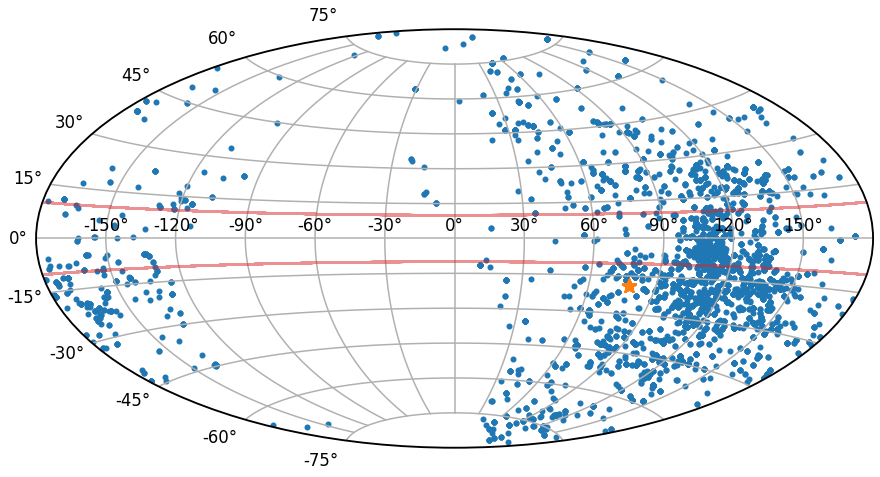

In [6]:
gal = SkyCoord(pdf_mulens['i:ra'], pdf_mulens['i:dec'], unit='deg').galactic

fig = plt.figure(figsize=(15, 10))

ax = plt.subplot(projection='aitoff')

mask_gal = np.abs(gal.b.deg)== 10
# We should better represent the galactic plane rather than just put 20 degree limitation (Petro)

plt.scatter(gal.l.wrap_at('180d').radian[~mask_gal], gal.b.radian[~mask_gal], color='C0', alpha=1, marker='.')
# Changed marker because why do we need different markers? (Petro)
plt.scatter(gal.l.wrap_at('180d').radian[mask_gal], gal.b.radian[mask_gal], color='C3', alpha=1, marker='.')

# Add ztf...
gal_single = SkyCoord(pdf_mulens_single['i:ra'], pdf_mulens_single['i:dec'], unit='deg').galactic
plt.scatter(
    gal_single.l.wrap_at('180d').radian, 
    gal_single.b.radian, color='C1', alpha=1, marker='*', s=200)

# gal_center = SkyCoord('17h45.6m', '−28.94deg').galactic
# plt.scatter(
#     gal_center.l.wrap_at('180d').radian, 
#     gal_center.b.radian, color='C1', alpha=1, marker='*', s=200)

x = np.arange(-180, 180, 0.1)
plt.plot(x, [10*np.pi/180]*len(x), color='C3', alpha=0.5)
plt.plot(x, [-10*np.pi/180]*len(x), color='C3', alpha=0.5)

plt.grid();
# (Petro)
blue_num = gal.l.wrap_at('180d').radian[~mask_gal].size # Number of blue dots
red_num = gal.l.wrap_at('180d').radian[mask_gal].size # Number of red dots
blue_num, red_num

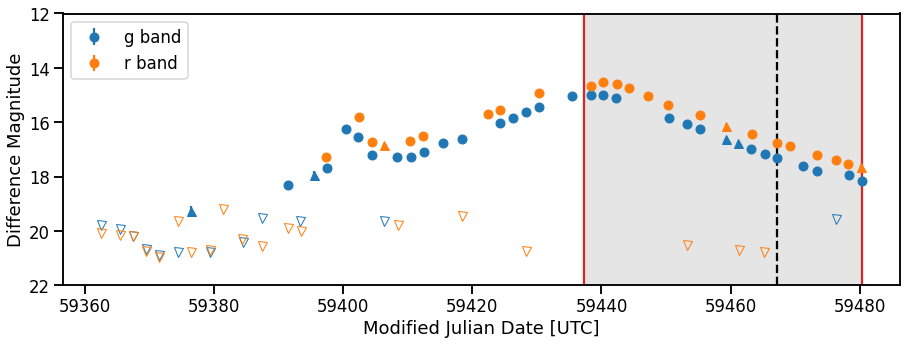

In [7]:
pdf_mulens_single = pdf_mulens_single.sort_values('i:jd')
mjd = pdf_mulens_single['i:jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_mulens_single['i:fid']):
    maskFilt = pdf_mulens_single['i:fid'] == filt

    # The column `d:tag` is used to check data type
    maskValid = pdf_mulens_single['d:tag'] == 'valid'
    plt.errorbar(
        pdf_mulens_single[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_mulens_single[maskValid & maskFilt]['i:magpsf'],
        pdf_mulens_single[maskValid & maskFilt]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )

    maskUpper = pdf_mulens_single['d:tag'] == 'upperlim'
    plt.plot(
        pdf_mulens_single[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_mulens_single[maskUpper & maskFilt]['i:diffmaglim'],
        ls='', marker='v', color=colordic[filt], markerfacecolor='none'
    )

    maskBadquality = pdf_mulens_single['d:tag'] == 'badquality'
    plt.errorbar(
        pdf_mulens_single[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_mulens_single[maskBadquality & maskFilt]['i:magpsf'],
        pdf_mulens_single[maskBadquality & maskFilt]['i:sigmapsf'],
        ls='', marker='^', color=colordic[filt]
    )
# Code might be shorter if we collect 'valid', 'upperquality' and 'badquality' into a single list (Petro)

    
# Highlight dates where it was flagged as an ML event
c0 = pdf_mulens_single['d:mulens'] > 0.0
jd0 = np.min(pdf_mulens_single[c0]['i:jd'].values)
minjd = np.min(pdf_mulens_single[c0]['i:jd'].values) - 30
maxjd = np.max(pdf_mulens_single[c0]['i:jd'].values)
plt.axvline(jd0 - 2400000.5, color='black', ls='--')
plt.axvline(minjd - 2400000.5, color='C3')
plt.axvline(maxjd - 2400000.5, color='C3')
plt.fill_betweenx([10, 25], minjd - 2400000.5, maxjd - 2400000.5, alpha=0.1, color='black')
# Why not convert all the dates at the beginning? (Petro)


plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
# plt.title(
#     'Object {}'.format(
#         pdf_mulens_single['i:objectId'].values[0]
#     )
# )
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');

_Circles (&#9679;) with error bars show valid alerts that pass the Fink quality cuts. Upper triangles with errors (&#9650;) represent alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by Fink science modules. Lower triangles (&#9661;) represent 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts._

The data in between the red lines is favoured as Microlensing by the classifier, and the first microlensing trigger is shown with the black line (recall alerts carry up to 30 days of history). On the Fink Science Portal, you can then try to extract Microlensing paramaters. The fit is done using [pyLIMA](https://github.com/ebachelet/pyLIMA) described in [Bachelet et al (2017)](https://ui.adsabs.harvard.edu/abs/2017AJ....154..203B/abstract). We used a simple PSPL model to fit the data. Here is a [link](https://fink-portal.org/ZTF18abktckv) in the portal for this event. Try pressing on "Microlensing" in upper right corner and "Fit data" on the right.

Let's try a different fit corresponding to Uniform-Source Binary Lens model:

In [8]:
# Take only valid measurements
pdf = pdf_mulens_single[pdf_mulens_single['d:tag'] == 'valid'].sort_values('i:jd', ascending=False)

# Use DC magnitude instead of difference mag
mag_dc, err_dc = np.transpose(
    [
        dc_mag(*args) for args in zip(
            pdf['i:fid'].astype(int).values,
            pdf['i:magpsf'].astype(float).values,
            pdf['i:sigmapsf'].astype(float).values,
            pdf['i:magnr'].astype(float).values,
            pdf['i:sigmagnr'].astype(float).values,
            pdf['i:magzpsci'].astype(float).values,
            pdf['i:isdiffpos'].values
        )
    ]
)

# pyLIMA magic
current_event = event.Event()
current_event.name = pdf['i:objectId'].values[0]

current_event.ra = pdf['i:ra'].values[0]
current_event.dec = pdf['i:dec'].values[0]

filts = {1: 'g', 2: 'r'}
for fid in np.unique(pdf['i:fid'].values):
    mask = pdf['i:fid'].values == fid
    telescope = telescopes.Telescope(
        name='ztf_{}'.format(filts[fid]),
        camera_filter=format(filts[fid]),
        light_curve_magnitude=np.transpose(
            [
                pdf['i:jd'].values[mask],
                mag_dc[mask],
                err_dc[mask]
            ]
        ),
        light_curve_magnitude_dictionnary={
            'time': 0,
            'mag': 1,
            'err_mag': 2
        }
    )

    current_event.telescopes.append(telescope)

# USBL model
mulens_model = microlmodels.create_model('USBL', current_event)
mulens_model.parameters_guess = [2459438.8042624635, 0.28967950357242556, 28.54840874346009, 0.04989598439800191, 0.272393673849404, -2.8730822458911205, 0.23513925488422255-np.pi] 
current_event.fit(mulens_model, 'TRF')

# 7 parameters model
dof = len(pdf) - 7 - 1

results = current_event.fits[0]

normalised_lightcurves = microltoolbox.align_the_data_to_the_reference_telescope(results, 0, results.fit_results)

# Model
create_the_fake_telescopes(results, results.fit_results)

telescope_ = results.event.fake_telescopes[0]

flux_model = mulens_model.compute_the_microlensing_model(telescope_, results.model.compute_pyLIMA_parameters(results.fit_results))[0]

time = telescope_.lightcurve_flux[:, 0]
magnitude = microltoolbox.flux_to_magnitude(flux_model)

# fitted parameters
names = results.model.model_dictionnary
params = results.fit_results
err = np.diag(np.sqrt(results.fit_covariance))


Start fit on ZTF18abktckv, with model USBL and method TRF
check_event  : Everything looks fine, this event can be fitted
initial_guess  : Initial parameters guess SUCCESS
trust_region_reflective  : TRF fit SUCCESS
[2459438.8991211574, 0.2871468077789471, 31.683401727586052, 0.0498339992814767, 0.25837231169930946, -2.289115433143932, -2.862808140663816, 37777.580054928825, 0.05023134555283798, 59591.03614688332, -0.007589339163579948, 355.4077409641731]


Finally plot the fit on top of the (rescaled) measurements:

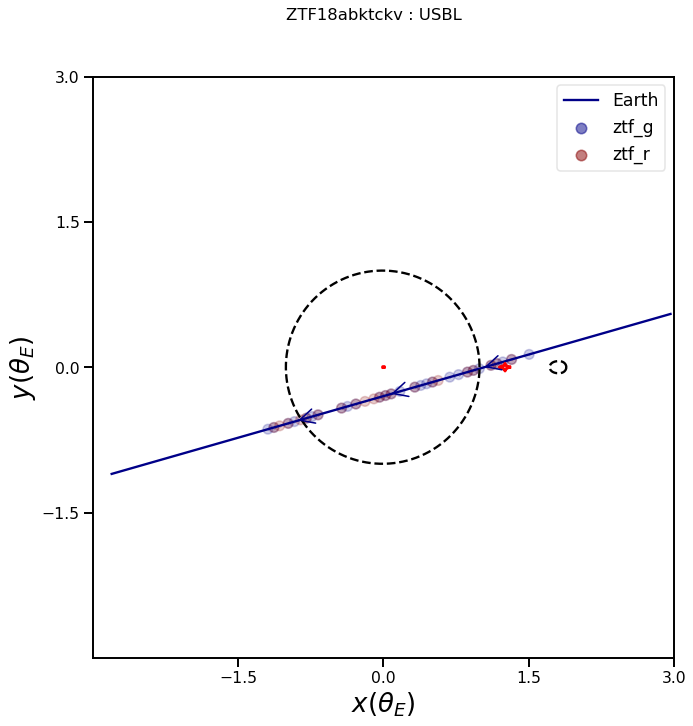

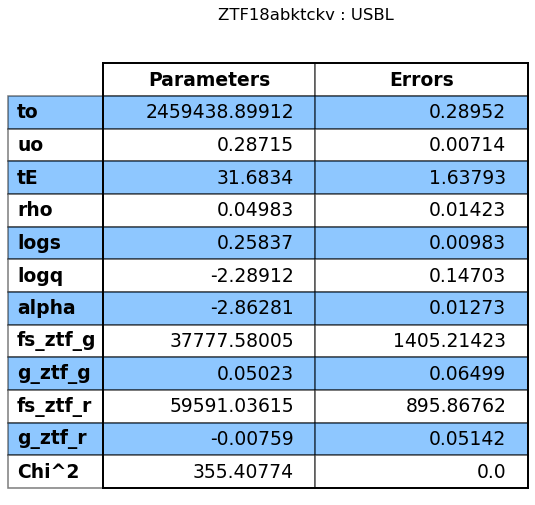

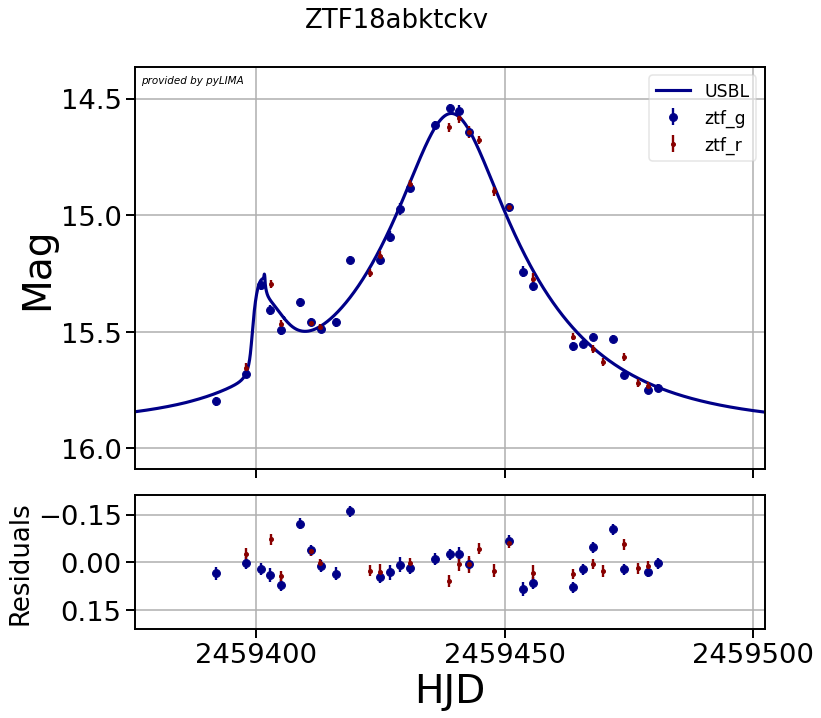

In [9]:
results.produce_outputs()
plt.show()

In [10]:
def get_model(current_event, mjd=True):
    # Model
    results = current_event.fits[0]
    create_the_fake_telescopes(results, results.fit_results)

    telescope_ = results.event.fake_telescopes[0]

    flux_model = mulens_model.compute_the_microlensing_model(
        telescope_, results.model.compute_pyLIMA_parameters(results.fit_results)
    )[0]

    time = telescope_.lightcurve_flux[:, 0]
    magnitude = microltoolbox.flux_to_magnitude(flux_model)
    
    if mjd:
        time = np.array([t - 2400000.5 for t in time])
        
    # params = results.fit_results
    # print(params)

    return time, magnitude

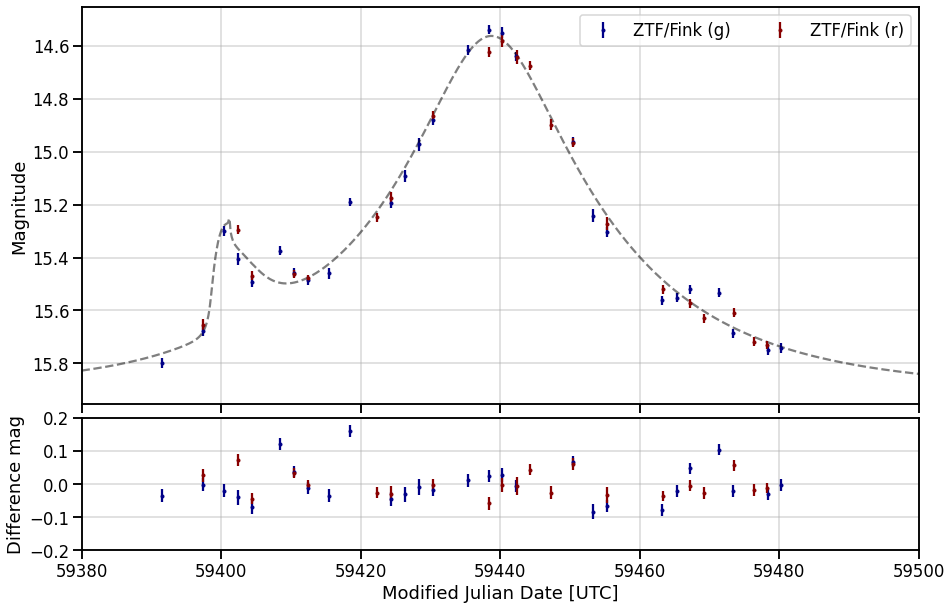

In [11]:
fig = plt.figure(figsize=(15, 10))

gs = plt.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# names_telescopes = ['ZTF (g)', 'ZTF (r)', 'ZTF (i)', 'GAIA']
name_telescopes = ['ZTF/Fink (g)', 'ZTF/Fink (r)']

for ax in [ax1]:
    for index, name in enumerate(name_telescopes):
        ax.errorbar(
            [t - 2400000.5 for t in normalised_lightcurves[index][:, 0]],
            normalised_lightcurves[index][:, 1],
            normalised_lightcurves[index][:, 2],
            ls='',
            marker='o',
            markersize=3,
            label=name
        )

        if index == 0:
            ax.plot(
                *get_model(current_event),
                color='black', ls='--', alpha=0.5
            )
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('Magnitude');
ax1.invert_yaxis()
ax1.legend(ncol=2)
ax1.grid(alpha=0.5)
ax1.set_xlim(59380, 59500)

t_model, mag_model = get_model(current_event)
for index, name in enumerate(name_telescopes):
    mag_inter = np.interp(
        [t - 2400000.5 for t in normalised_lightcurves[index][:, 0]], 
        t_model, 
        mag_model
    )
    ax2.errorbar(
        [t - 2400000.5 for t in normalised_lightcurves[index][:, 0]],
        mag_inter - normalised_lightcurves[index][:, 1],
        normalised_lightcurves[index][:, 2],
        ls='',
        marker='o',
        markersize=3,
        label=name
    )

ax2.grid(alpha=0.5)
ax2.set_xlabel('Modified Julian Date [UTC]');
ax2.set_ylim(-0.2, 0.2)
ax2.set_ylabel('Difference mag');

In [12]:
msg = """
# Fitted parameters
t0: {:.2f} +/- {:.2f} (MJD)
tE: {:.2f} +/- {:.2f} (days)
u0: {:.2f} +/- {:.2f}
rho: {:.2f} +/- {:.2f}
logs: {:.2f} +/- {:.2f}
logq: {:.2f} +/- {:.2f}
alpha: {:.2f} +/- {:.2f}
fs_ztf_g: {:.2f} +/- {:.2f}
g_ztf_g: {:.2f} +/- {:.2f}
fs_ztf_r: {:.2f} +/- {:.2f}
g_ztf_r: {:.2f} +/- {:.2f}
chi2/dof: {:.2f}
""".format(
    params[names['to']] - 2400000.5,
    err[names['to']],
    params[names['tE']],
    err[names['tE']],
    params[names['uo']],
    err[names['uo']],
    params[names['rho']],
    err[names['rho']],
    params[names['logs']],
    err[names['logs']],
    params[names['logq']],
    err[names['logq']],
    params[names['alpha']],
    err[names['alpha']],
    params[names['fs_ztf_g']],
    err[names['fs_ztf_g']],
    params[names['g_ztf_g']],
    err[names['g_ztf_g']],
    params[names['fs_ztf_r']],
    err[names['fs_ztf_r']],
    params[names['g_ztf_r']],
    err[names['g_ztf_r']],
    params[-1] / dof
)
print(msg)


# Fitted parameters
t0: 59438.40 +/- 0.29 (MJD)
tE: 31.68 +/- 1.64 (days)
u0: 0.29 +/- 0.01
rho: 0.05 +/- 0.01
logs: 0.26 +/- 0.01
logq: -2.29 +/- 0.15
alpha: -2.86 +/- 0.01
fs_ztf_g: 37777.58 +/- 1405.21
g_ztf_g: 0.05 +/- 0.06
fs_ztf_r: 59591.04 +/- 895.87
g_ztf_r: -0.01 +/- 0.05
chi2/dof: 8.67



Not too bad - although we need much more data to conclude on the nature of the object ;-) We didn't have baseline but now we will take it from ZTF data.

### Inspecting the event using the full ZTF lightcurve

For further analysis we will prepare forced ZTF data, Gaia data and ASASSN data:

In [13]:
'''
# Take ZTF data from server
maskNone = pdf_mulens_single['d:tag'] == 'valid'
ra0 = np.mean(pdf_mulens_single[maskNone]['i:ra'].values)
dec0 = np.mean(pdf_mulens_single[maskNone]['i:dec'].values)

r = requests.post(
    'https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves', 
    data={'POS': 'CIRCLE {} {} 0.0004'.format(ra0, dec0), 
          'BAD_CATFLAGS_MASK': 32768, 
          'FORMAT': 'csv'
         }
)

pdf_ZTF = pd.read_csv(io.StringIO(r.text))

# Forced ZTF data (g, r, i bands)
pdf_ZTF_g = pd.read_csv('Data/ZTF18abktckv_g.dat', sep=' ', comment='#', header=None)
pdf_ZTF_g.columns = ["JD", "mag", "mag_err", "a"]
# We don't need the last column
del pdf_ZTF_g["a"]
pdf_ZTF_r = pd.read_csv('Data/ZTF18abktckv_r.dat', sep=' ', comment='#', header=None)
pdf_ZTF_r.columns = ["JD", "mag", "mag_err", "a"]
del pdf_ZTF_r["a"]
pdf_ZTF_i = pd.read_csv('Data/ZTF18abktckv_i.dat', sep=' ', comment='#', header=None)
pdf_ZTF_i.columns = ["JD", "mag", "mag_err", "a"]
del pdf_ZTF_i["a"]


pdf_ZTF_g
'''

'\n# Take ZTF data from server\nmaskNone = pdf_mulens_single[\'d:tag\'] == \'valid\'\nra0 = np.mean(pdf_mulens_single[maskNone][\'i:ra\'].values)\ndec0 = np.mean(pdf_mulens_single[maskNone][\'i:dec\'].values)\n\nr = requests.post(\n    \'https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves\', \n    data={\'POS\': \'CIRCLE {} {} 0.0004\'.format(ra0, dec0), \n          \'BAD_CATFLAGS_MASK\': 32768, \n          \'FORMAT\': \'csv\'\n         }\n)\n\npdf_ZTF = pd.read_csv(io.StringIO(r.text))\n\n# Forced ZTF data (g, r, i bands)\npdf_ZTF_g = pd.read_csv(\'Data/ZTF18abktckv_g.dat\', sep=\' \', comment=\'#\', header=None)\npdf_ZTF_g.columns = ["JD", "mag", "mag_err", "a"]\n# We don\'t need the last column\ndel pdf_ZTF_g["a"]\npdf_ZTF_r = pd.read_csv(\'Data/ZTF18abktckv_r.dat\', sep=\' \', comment=\'#\', header=None)\npdf_ZTF_r.columns = ["JD", "mag", "mag_err", "a"]\ndel pdf_ZTF_r["a"]\npdf_ZTF_i = pd.read_csv(\'Data/ZTF18abktckv_i.dat\', sep=\' \', comment=\'#\', header=None)\npdf_ZTF_

In [14]:
# Forced ZTF data
pdf_ZTF = pd.read_csv('Data/forcedphotometry_req00100242_lc.txt', comment='#', sep=' ')
pdf_ZTF = pdf_ZTF\
    .drop(columns=['Unnamed: 0'])\
    .rename(lambda x: x.split(',')[0], axis='columns')
np.unique(pdf_ZTF["filter"]), pdf_ZTF

(array(['ZTF_g', 'ZTF_i', 'ZTF_r'], dtype=object),
       index  field  ccdid  qid filter            pid  infobitssci  \
 0         0    643     10    3  ZTF_r   474458343915            0   
 1         1    643     10    3  ZTF_g   474487153915            0   
 2         2    643     10    3  ZTF_g   482432113915            0   
 3         3    643     10    3  ZTF_g   488443743915            0   
 4         4    643     10    3  ZTF_r   488466463915            0   
 ...     ...    ...    ...  ...    ...            ...          ...   
 1963   1963    643     10    3  ZTF_i  1788140393915            0   
 1964   1964    643     10    3  ZTF_r  1788158633915            0   
 1965   1965    643     10    3  ZTF_r  1789115183915            0   
 1966   1966    643     10    3  ZTF_g  1789156563915            0   
 1967   1967    643     10    3  ZTF_g  1796178103915            0   
 
       sciinpseeing  scibckgnd  scisigpix  ...  forcediffimsnrap  aperturecorr  \
 0           3.6147   129

The default data is difference image PSF-fit flux (similar to alerts). Generating absolute-photometry lightcurves for variable sources:

In [15]:
def diff_phot(forcediffimflux, forcediffimfluxunc, zpdiff, SNT=3, SNU=5, set_to_nan=True):
    """
    """
    if (forcediffimflux / forcediffimfluxunc) > SNT:
        # we have a confident detection, compute and plot mag with error bar:
        mag = zpdiff - 2.5 * np.log10(forcediffimflux)
        err = 1.0857 * forcediffimfluxunc / forcediffimflux
    else:
        # compute flux upper limit and plot as arrow:
        if not set_to_nan:
            mag = zpdiff - 2.5 * np.log10(SNU * forcediffimfluxunc)
        else:
            mag = np.nan
        err = np.nan
        
    return mag, err
    
def apparent_flux(magpsf, sigmapsf, magnr, sigmagnr, magzpsci):
    """ Compute apparent flux from difference magnitude supplied by ZTF
    This was heavily influenced by the computation provided by Lasair:
    https://github.com/lsst-uk/lasair/blob/master/src/alert_stream_ztf/common/mag.py
    Paramters
    ---------
    fid
        filter, 1 for green and 2 for red
    magpsf,sigmapsf; floats
        magnitude from PSF-fit photometry, and 1-sigma error
    magnr,sigmagnr: floats
        magnitude of nearest source in reference image PSF-catalog
        within 30 arcsec and 1-sigma error
    magzpsci: float
        Magnitude zero point for photometry estimates
    isdiffpos: str
        t or 1 => candidate is from positive (sci minus ref) subtraction;
        f or 0 => candidate is from negative (ref minus sci) subtraction

    Returns
    --------
    dc_flux: float
        Apparent magnitude
    dc_sigflux: float
        Error on apparent magnitude
    """
    if magpsf is None:
        return None, None

    # reference flux and its error
    magdiff = magzpsci - magnr
    if magdiff > 12.0:
        magdiff = 12.0
    ref_flux = 10**(0.4 * magdiff)
    ref_sigflux = (sigmagnr / 1.0857) * ref_flux

    magdiff = magzpsci - magpsf
    if magdiff > 12.0:
        magdiff = 12.0
    difference_flux = 10**(0.4 * magdiff)
    difference_sigflux = (sigmapsf / 1.0857) * difference_flux

    dc_flux = ref_flux + difference_flux

    # assumes errors are independent. Maybe too conservative.
    dc_sigflux = np.sqrt(difference_sigflux**2 + ref_sigflux**2)

    return dc_flux, dc_sigflux

def dc_mag(magpsf, sigmapsf, magnr, sigmagnr, magzpsci):
    """ Compute apparent magnitude from difference magnitude supplied by ZTF
    Parameters
    Stolen from Lasair.
    ----------
    fid
        filter, 1 for green and 2 for red
    magpsf,sigmapsf
        magnitude from PSF-fit photometry, and 1-sigma error
    magnr,sigmagnr
        magnitude of nearest source in reference image PSF-catalog
        within 30 arcsec and 1-sigma error
    magzpsci
        Magnitude zero point for photometry estimates
    isdiffpos
        t or 1 => candidate is from positive (sci minus ref) subtraction;
        f or 0 => candidate is from negative (ref minus sci) subtraction
    """
    dc_flux, dc_sigflux = apparent_flux(
        magpsf, sigmapsf, magnr, sigmagnr, magzpsci
    )

    # apparent mag and its error from fluxes
    if (dc_flux == dc_flux) and dc_flux > 0.0:
        dc_mag = magzpsci - 2.5 * np.log10(dc_flux)
        dc_sigmag = dc_sigflux / dc_flux * 1.0857
    else:
        dc_mag = np.nan
        dc_sigmag = np.nan

    return dc_mag, dc_sigmag

Difference image PSF-fit flux to difference image PSF-fit magnitude:

In [16]:
magpsf, sigmapsf = np.transpose(
    [
        diff_phot(*args) for args in zip(
            pdf_ZTF['forcediffimflux'],
            pdf_ZTF['forcediffimfluxunc'].values,
            pdf_ZTF['zpdiff'].values,
        )
    ]
)

Difference image PSF-fit magnitude to absolute magnitude (DC):

In [17]:
mag_dc, err_dc = np.transpose(
    [
        dc_mag(*args) for args in zip(
            magpsf,
            sigmapsf,
            pdf_ZTF['nearestrefmag'].values,
            pdf_ZTF['nearestrefmagunc'].values,
            pdf_ZTF['zpmaginpsci'].values,
        )
    ]
)

Now we will form pandas dataframe for each of the ZTF's color filters (we will keep only the measurements with quality flag = 0):

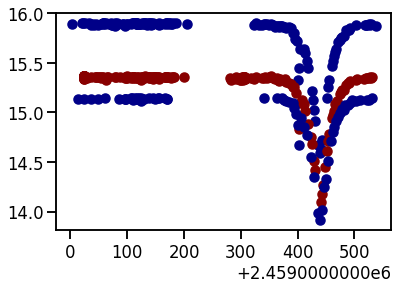

In [18]:
# Forced ZTF g band
mask = pdf_ZTF['filter'] == 'ZTF_g'
# Keep only measurements with flag = 0
mask *= pdf_ZTF['infobitssci'] == 0
sub = pdf_ZTF[mask]
# The ZTF data is in JD
df_ZTF_g = {'JD': sub['jd'], 'mag': mag_dc[mask], 'mag_err': err_dc[mask]}
pdf_ZTF_g = pd.DataFrame(data=df_ZTF_g)
pdf_ZTF_g = pdf_ZTF_g.drop(pdf_ZTF_g[pdf_ZTF_g["mag"].isnull()].index) # We remove rows with NaN magnitudes
# We will cut the baseline a little, because we don't need as much
pdf_ZTF_g = pdf_ZTF_g.drop(pdf_ZTF_g[pdf_ZTF_g["JD"] < 2.45900e6].index) 
plt.scatter(pdf_ZTF_g["JD"], pdf_ZTF_g["mag"])

# Forced ZTF r band
mask = pdf_ZTF['filter'] == 'ZTF_r'
# Keep only measurements with flag = 0
mask *= pdf_ZTF['infobitssci'] == 0
sub = pdf_ZTF[mask]
# The ZTF data is in JD
df_ZTF_r = {'JD': sub['jd'], 'mag': mag_dc[mask], 'mag_err': err_dc[mask]}
pdf_ZTF_r = pd.DataFrame(data=df_ZTF_r)
pdf_ZTF_r = pdf_ZTF_r.drop(pdf_ZTF_r[pdf_ZTF_r["mag"].isnull()].index) # We remove rows with NaN magnitudes
# We will cut the baseline a little, because we don't need as much
pdf_ZTF_r = pdf_ZTF_r.drop(pdf_ZTF_r[pdf_ZTF_r["JD"] < 2.45900e6].index) 
plt.scatter(pdf_ZTF_r["JD"], pdf_ZTF_r["mag"])

# Forced ZTF i band
mask = pdf_ZTF['filter'] == 'ZTF_i'
# Keep only measurements with flag = 0
mask *= pdf_ZTF['infobitssci'] == 0
sub = pdf_ZTF[mask]
# The ZTF data is in JD
df_ZTF_i = {'JD': sub['jd'], 'mag': mag_dc[mask], 'mag_err': err_dc[mask]}
pdf_ZTF_i = pd.DataFrame(data=df_ZTF_i)
pdf_ZTF_i = pdf_ZTF_i.drop(pdf_ZTF_i[pdf_ZTF_i["mag"].isnull()].index) # We remove rows with NaN magnitudes
# We will cut the baseline a little, because we don't need as much
pdf_ZTF_i = pdf_ZTF_i.drop(pdf_ZTF_i[pdf_ZTF_i["JD"] < 2.45900e6].index) 
plt.scatter(pdf_ZTF_i["JD"], pdf_ZTF_i["mag"])

In [19]:
# Gaia data (need to clean code like below)
pdf_Gaia = np.loadtxt('./Data/Gaia.dat',dtype=str)
mask = (pdf_Gaia[:,1]=='untrusted') |  (pdf_Gaia[:,1]=='null') # we will remove rows with untrusted or null mag
pdf_Gaia = pdf_Gaia[~mask]
pdf_Gaia = pdf_Gaia[:,[0,1]].astype(float)
errors = [estimateGaiaError(i) for i in pdf_Gaia[:,1]] # we also calculate the error for each magnitude
pdf_Gaia = np.c_[pdf_Gaia,errors]
pdf_Gaia = pd.DataFrame(pdf_Gaia, columns = ['JD','mag','mag_err'])
# We will cut the baseline a little, because we don't need as much
pdf_Gaia = pdf_Gaia.drop(pdf_Gaia[pdf_Gaia["JD"] < 2.45900e6].index)

# ASASNN data
pdf_ASASSN = pd.read_csv('Data/ASASSN.dat', sep='\t', header=None)
pdf_ASASSN.columns = ["JD", "mag", "mag_err"]
# In this dataset there are some rows where we have value of 99.99. It's a placeholder for NaN, I suppose
pdf_ASASSN = pdf_ASASSN.drop(pdf_ASASSN[(pdf_ASASSN["mag"] > 90) | (pdf_ASASSN["mag_err"] > 90)].index)
# We will cut the baseline a little, because we don't need as much
pdf_ASASSN = pdf_ASASSN.drop(pdf_ASASSN[pdf_ASASSN["JD"] < 2.45900e6].index)

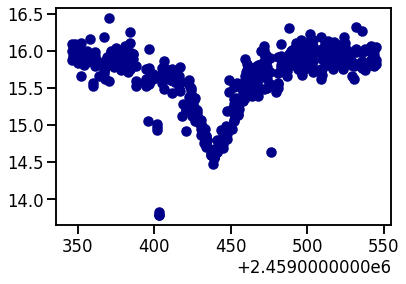

In [20]:
#plt.scatter(pdf_ZTF_g["JD"], pdf_ZTF_g["mag"])
#plt.scatter(pdf_ZTF_r["JD"], pdf_ZTF_r["mag"])
plt.scatter(pdf_ASASSN["JD"], pdf_ASASSN["mag"])

Having loaded all the data, we can start building fit.

In [21]:
### pyLIMA magic

# Firstly, we create an event
mulens_event = event.Event()
mulens_event.name = 'ZTF18abktckv'
mulens_event.ra = 324.545078 
mulens_event.dec = 26.4664299

#Secondly, we add telescopes
telescope_ZTF_g = telescopes.Telescope(name='ZTF_g', camera_filter='g', light_curve_magnitude=pdf_ZTF_g.to_numpy())
mulens_event.telescopes.append(telescope_ZTF_g)
telescope_ZTF_r = telescopes.Telescope(name='ZTF_r', camera_filter='r', light_curve_magnitude=pdf_ZTF_r.to_numpy())
mulens_event.telescopes.append(telescope_ZTF_r)
telescope_ZTF_i = telescopes.Telescope(name='ZTF_i', camera_filter='i', light_curve_magnitude=pdf_ZTF_i.to_numpy())
mulens_event.telescopes.append(telescope_ZTF_i)
telescope_Gaia = telescopes.Telescope(name='Gaia', camera_filter='G', light_curve_magnitude=pdf_Gaia.to_numpy())
mulens_event.telescopes.append(telescope_Gaia)
#
telescope_ASASSN = telescopes.Telescope(name='ASASSN', camera_filter='g', light_curve_magnitude=pdf_ASASSN.to_numpy())
mulens_event.telescopes.append(telescope_ASASSN)

mulens_event.find_survey('ZTF_g')

# Sanity check
mulens_event.check_event()

check_event  : Everything looks fine, this event can be fitted


Parallax(Full) estimated for the telescope ZTF_g: SUCCESS
Parallax(Full) estimated for the telescope ZTF_r: SUCCESS
Parallax(Full) estimated for the telescope ZTF_i: SUCCESS
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope ASASSN: SUCCESS

Start fit on ZTF18abktckv, with model USBL and method MCMC
check_event  : Everything looks fine, this event can be fitted
pre MCMC done


100%|███████████████████████████████████████| 1000/1000 [10:12<00:00,  1.63it/s]


MCMC preburn done


100%|███████████████████████████████████████| 1000/1000 [10:17<00:00,  1.62it/s]


MCMC  : MCMC fit SUCCESS
Parallax(Full) estimated for the telescope ZTF_g: SUCCESS
-7532.437660977663
Chi2_LM : 15064.875321955325


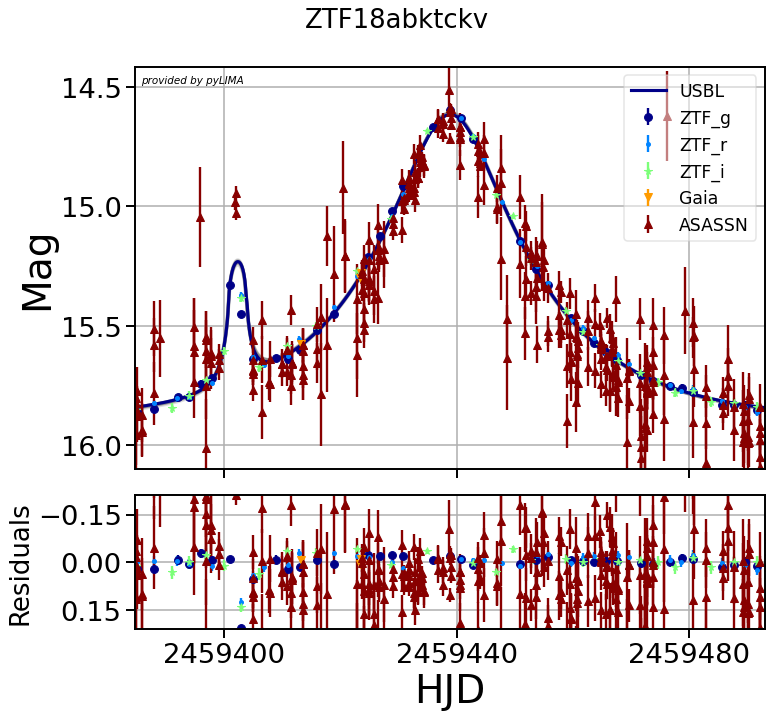

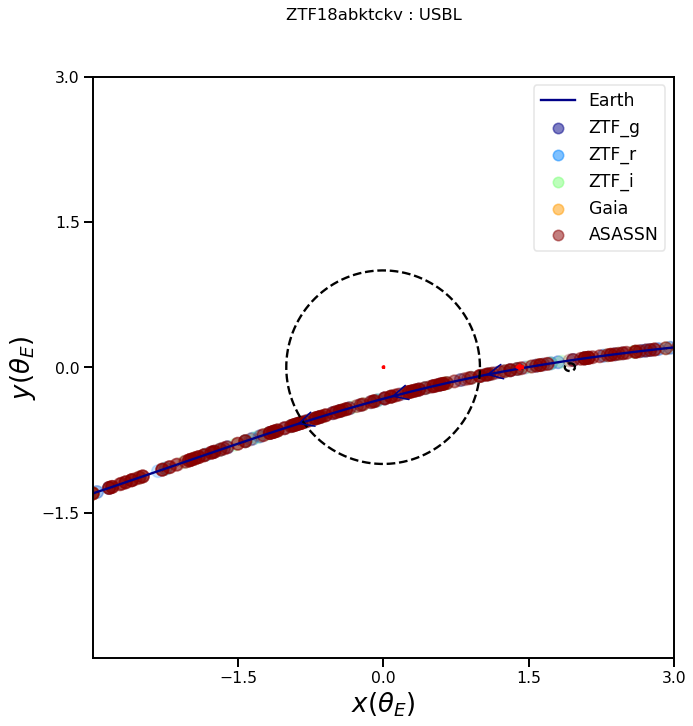

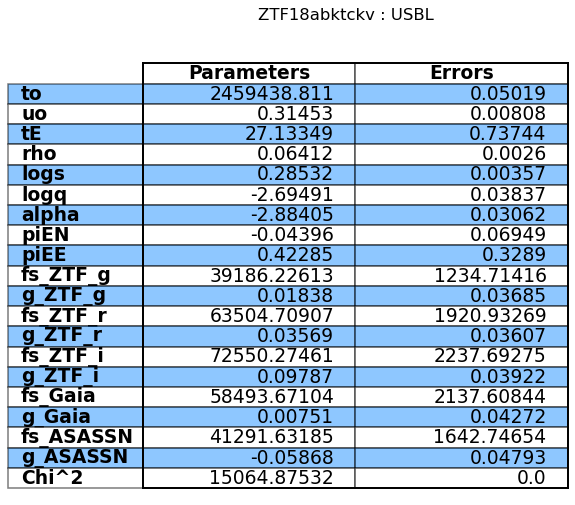

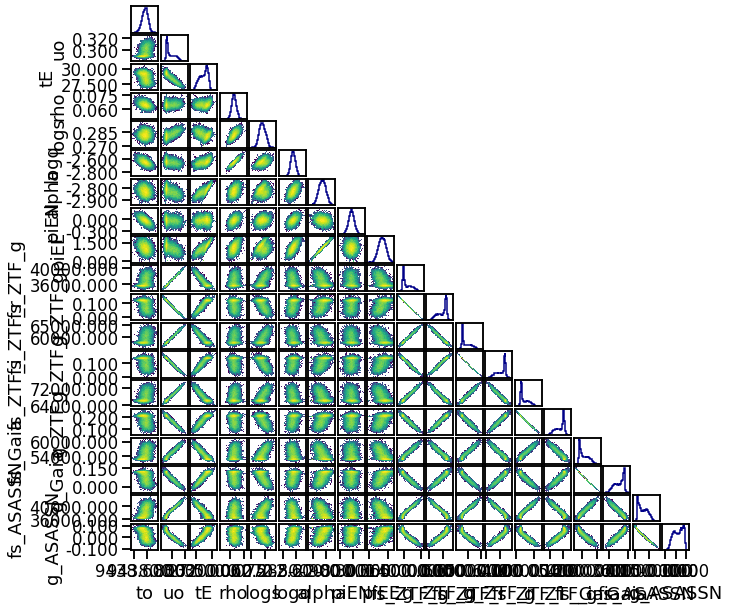

In [22]:
# We will also paralelize our fit because it takes too much time on 1 core
from multiprocessing import Pool
pool =  Pool(processes = 16)

# Now we construct the model we want to fit
model_USBL = microlmodels.create_model('USBL', mulens_event, parallax=['Full', 2459438.79826])
model_USBL.parameters_guess = [2459438.8042624635, 0.28967950357242556, 28.54840874346009, 0.04989598439800191, 0.272393673849404, -2.8730822458911205, 0.23513925488422255-np.pi, 0, 0] 
model_USBL.parameters_boundaries[3] = [0,0.1]
mulens_event.fit(model_USBL,'MCMC', computational_pool = pool)

# And now we produce some plots
mulens_event.fits[0].produce_outputs()
print(np.max(mulens_event.fits[0].MCMC_chains[:,-1]))
print('Chi2_LM :',mulens_event.fits[0].outputs.fit_parameters.chichi)
plt.show()

In [23]:
print(len(pdf_ZTF_r) + len(pdf_ZTF_g) + len(pdf_ZTF_i) + len(pdf_Gaia) + len(pdf_ASASSN) - 7 - 1)
#print(mulens_event.fits[0].outputs.fit_parameters.chichi/(len(pdf_ZTF_r) + len(pdf_ZTF_g) + len(pdf_ZTF_i) + len(pdf_Gaia) + len(pdf_ASASSN) - 7 - 1))
#print(np.max(mulens_event.fits[0].MCMC_chains[:,-1]))
'''
telescope_ASASSN = telescopes.Telescope(name='ASASSN', camera_filter='g', light_curve_magnitude=pdf_ASASSN.to_numpy())
mulens_event.telescopes.append(telescope_ASASSN)
mulens_event.check_event()
# Now we construct the model we want to fit
model_PSPL = microlmodels.create_model('USBL', mulens_event)
model_PSPL.parameters_guess = [2459438.8042624635, 0.28967950357242556, 28.54840874346009, 0.04989598439800191, 0.272393673849404, -2.8730822458911205, 0.23513925488422255-np.pi] 
mulens_event.fit(model_PSPL,'MCMC', computational_pool = pool)

# And now we produce some plots
mulens_event.fits[0].produce_outputs()
print('Chi2_LM :',mulens_event.fits[0].outputs.fit_parameters.chichi)
plt.show()
'''

1080


"\ntelescope_ASASSN = telescopes.Telescope(name='ASASSN', camera_filter='g', light_curve_magnitude=pdf_ASASSN.to_numpy())\nmulens_event.telescopes.append(telescope_ASASSN)\nmulens_event.check_event()\n# Now we construct the model we want to fit\nmodel_PSPL = microlmodels.create_model('USBL', mulens_event)\nmodel_PSPL.parameters_guess = [2459438.8042624635, 0.28967950357242556, 28.54840874346009, 0.04989598439800191, 0.272393673849404, -2.8730822458911205, 0.23513925488422255-np.pi] \nmulens_event.fit(model_PSPL,'MCMC', computational_pool = pool)\n\n# And now we produce some plots\nmulens_event.fits[0].produce_outputs()\nprint('Chi2_LM :',mulens_event.fits[0].outputs.fit_parameters.chichi)\nplt.show()\n"

Next code sections are under construction...

In [24]:
'''
pdf_mulens_single = pdf_mulens_single.sort_values('i:jd')
mjd = pdf_mulens_single['i:jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(15, 6))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_mulens_single['i:fid']):
    maskFilt = pdf_mulens_single['i:fid'] == filt

    # The column `d:tag` is used to check data type
    maskValid = pdf_mulens_single['d:tag'] == 'valid'
    
    # Use DC magnitude
    mag_dc, err_dc = np.transpose(
        [
            dc_mag(*args) for args in zip(
                pdf_mulens_single[maskValid & maskFilt]['i:fid'].astype(int).values,
                pdf_mulens_single[maskValid & maskFilt]['i:magpsf'].astype(float).values,
                pdf_mulens_single[maskValid & maskFilt]['i:sigmapsf'].astype(float).values,
                pdf_mulens_single[maskValid & maskFilt]['i:magnr'].astype(float).values,
                pdf_mulens_single[maskValid & maskFilt]['i:sigmagnr'].astype(float).values,
                pdf_mulens_single[maskValid & maskFilt]['i:magzpsci'].astype(float).values,
                pdf_mulens_single[maskValid & maskFilt]['i:isdiffpos'].values
            )
        ]
    )

    
    plt.errorbar(
        pdf_mulens_single[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        mag_dc,
        err_dc,
        ls = '', marker='o', color=colordic[filt], 
        label='{} band'.format(filtdic[filt])
    )

    
# Highlight dates where it was flagged as an ML event
c0 = pdf_mulens_single['d:mulens'] > 0.0
jd0 = np.min(pdf_mulens_single[c0]['i:jd'].values)
minjd = np.min(pdf_mulens_single[c0]['i:jd'].values) - 30
maxjd = np.max(pdf_mulens_single[c0]['i:jd'].values)
plt.axvline(jd0 - 2400000.5, color='black', ls='--')
plt.axvline(minjd - 2400000.5, color='C3')
plt.axvline(maxjd - 2400000.5, color='C3')
plt.fill_betweenx([15, 25], minjd - 2400000.5, maxjd - 2400000.5, alpha=0.1, color='black')


colordic = {'zg': 'C0', 'zr': 'C1', 'zi': 'C2'}
for filt in np.unique(pdf_ZTF['filtercode']):
    maskFilt = pdf_ZTF['filtercode'] == filt
    plt.errorbar(
        pdf_ZTF[maskFilt]['mjd'], 
        pdf_ZTF[maskFilt]['mag'], 
        pdf_ZTF[maskFilt]['magerr'], 
        ls='', color=colordic[filt], alpha=0.5,
        label='ZTF DR {} band'.format(filt))

plt.ylim(16, 14)
#plt.gca().invert_yaxis()
plt.legend(ncol=3)
plt.title(
    'Object {}'.format(
        pdf_mulens_single['i:objectId'].values[0]
    )
)
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');
'''

"\npdf_mulens_single = pdf_mulens_single.sort_values('i:jd')\nmjd = pdf_mulens_single['i:jd'].apply(lambda x: x - 2400000.5)\n\nfig = plt.figure(figsize=(15, 6))\n\ncolordic = {1: 'C0', 2: 'C1'}\nfiltdic = {1: 'g', 2: 'r'}\n\nfor filt in np.unique(pdf_mulens_single['i:fid']):\n    maskFilt = pdf_mulens_single['i:fid'] == filt\n\n    # The column `d:tag` is used to check data type\n    maskValid = pdf_mulens_single['d:tag'] == 'valid'\n    \n    # Use DC magnitude\n    mag_dc, err_dc = np.transpose(\n        [\n            dc_mag(*args) for args in zip(\n                pdf_mulens_single[maskValid & maskFilt]['i:fid'].astype(int).values,\n                pdf_mulens_single[maskValid & maskFilt]['i:magpsf'].astype(float).values,\n                pdf_mulens_single[maskValid & maskFilt]['i:sigmapsf'].astype(float).values,\n                pdf_mulens_single[maskValid & maskFilt]['i:magnr'].astype(float).values,\n                pdf_mulens_single[maskValid & maskFilt]['i:sigmagnr'].astype(flo

Certainly not a variable star! Perfect!

Now we will test the model again but this time we will have the baseline.

In [25]:
'''
# pyLIMA magic
current_event = event.Event()
current_event.name = 'ZTF18abktckv'

current_event.ra = pdf_ZTF['ra'].values[0]
current_event.dec = pdf_ZTF['dec'].values[0]

filts = {'zg': 'g', 'zr': 'r', 'zi': 'i'}
for fid in ['zg','zr', 'zi']:
    mask = pdf_ZTF['filtercode'].values == fid
    telescope = telescopes.Telescope(
        name='ztf_{}'.format(filts[fid]),
        camera_filter=format(filts[fid]),
        light_curve_magnitude=np.transpose(
            [
                pdf_ZTF['mjd'].values[mask]+2400000.5,
                pdf_ZTF['mag'][mask],
                pdf_ZTF['magerr'][mask]
            ]
        ),
        light_curve_magnitude_dictionnary={
            'time': 0,
            'mag': 1,
            'err_mag': 2
        }
    )

    current_event.telescopes.append(telescope)

    
### Gaia
lightcurve = np.loadtxt('./Data/Gaia.dat',dtype=str)

mask = (lightcurve[:,1]=='untrusted') |  (lightcurve[:,1]=='null')
lightcurve = lightcurve[~mask]
lightcurve = lightcurve[:,[0,1]].astype(float)
errors = [estimateGaiaError(i) for i in lightcurve[:,1]]
lightcurve = np.c_[lightcurve,errors]
telescope = telescopes.Telescope(
        name='Gaia',
        camera_filter='G',
        light_curve_magnitude=lightcurve
        )
current_event.telescopes.append(telescope)
    
    
# USBL model -- TRF
mulens_model = microlmodels.create_model('USBL', current_event)
mulens_model.parameters_guess = [2459438.8042624635, 0.28967950357242556, 28.54840874346009, 0.04989598439800191, 0.272393673849404, -2.8730822458911205, 0.23513925488422255-np.pi] 
current_event.fit(mulens_model, 'TRF')
current_event.fits[0].produce_outputs()
plt.show()    

# USBL model -- MCMC
mulens_model = microlmodels.create_model('USBL', current_event)
mulens_model.parameters_guess = [2459438.8042624635, 0.28967950357242556, 28.54840874346009, 0.04989598439800191, 0.272393673849404, -2.8730822458911205, 0.23513925488422255-np.pi] 
current_event.fit(mulens_model, 'MCMC')
'''

"\n# pyLIMA magic\ncurrent_event = event.Event()\ncurrent_event.name = 'ZTF18abktckv'\n\ncurrent_event.ra = pdf_ZTF['ra'].values[0]\ncurrent_event.dec = pdf_ZTF['dec'].values[0]\n\nfilts = {'zg': 'g', 'zr': 'r', 'zi': 'i'}\nfor fid in ['zg','zr', 'zi']:\n    mask = pdf_ZTF['filtercode'].values == fid\n    telescope = telescopes.Telescope(\n        name='ztf_{}'.format(filts[fid]),\n        camera_filter=format(filts[fid]),\n        light_curve_magnitude=np.transpose(\n            [\n                pdf_ZTF['mjd'].values[mask]+2400000.5,\n                pdf_ZTF['mag'][mask],\n                pdf_ZTF['magerr'][mask]\n            ]\n        ),\n        light_curve_magnitude_dictionnary={\n            'time': 0,\n            'mag': 1,\n            'err_mag': 2\n        }\n    )\n\n    current_event.telescopes.append(telescope)\n\n    \n### Gaia\nlightcurve = np.loadtxt('./Data/Gaia.dat',dtype=str)\n\nmask = (lightcurve[:,1]=='untrusted') |  (lightcurve[:,1]=='null')\nlightcurve = lightcur

In [26]:
current_event.fits[1].produce_outputs()
plt.show()

IndexError: list index out of range

In [ ]:
# 7 parameters model (USBL)
dof = len(pdf_ZTF) - 7 - 1

results = current_event.fits[0]

normalised_lightcurves = microltoolbox.align_the_data_to_the_reference_telescope(
    results, 0, results.fit_results)

In [ ]:
# Model
create_the_fake_telescopes(results, results.fit_results)

telescope_ = results.event.fake_telescopes[0]

flux_model = mulens_model.compute_the_microlensing_model(telescope_, results.model.compute_pyLIMA_parameters(results.fit_results))[0]

time = telescope_.lightcurve_flux[:, 0]
magnitude = microltoolbox.flux_to_magnitude(flux_model)

# fitted parameters
names = results.model.model_dictionnary
params = results.fit_results
err = np.diag(np.sqrt(results.fit_covariance))

In [ ]:
l = []
for name in ['to', 'uo', 'tE', 'rho', 'logs', 'logq', 'alpha']:
    l.append(getattr(current_event.fits[1].outputs.fit_parameters, name))
print(l)

In [ ]:
# restore default plot settings
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [ ]:
fig = plt.figure(figsize=(15, 10))

gs = GridSpec(2, 1, height_ratios=[4, 1], hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
axins = ax1.inset_axes([0.15, 0.3, 0.65, 0.5])
name_telescopes = ['ZTF (g)', 'ZTF (r)', 'ZTF (i)', 'Gaia']
# name_telescopes = ['ZTF (g)', 'ZTF (r)', 'ZTF (i)']

for ax in [ax1, axins]:
    for index, name in enumerate(name_telescopes):
        ax.errorbar(
            [t - 2400000.5 for t in normalised_lightcurves[index][:, 0]],
            normalised_lightcurves[index][:, 1],
            normalised_lightcurves[index][:, 2],
            ls='',
            marker='o',
            markersize=3,
            label=name
        )

        if index == 0:
            ax.plot(
                *get_model(current_event),
                color='black', ls='--', alpha=0.5
            )
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('Magnitude');
ax1.invert_yaxis()
ax1.legend(ncol=2)
ax1.grid(alpha=0.5)

axins.set_xlim(59350, 59550)
axins.invert_yaxis()

t_model, mag_model = get_model(current_event)
for index, name in enumerate(name_telescopes):
    mag_inter = np.interp(
        [t - 2400000.5 for t in normalised_lightcurves[index][:, 0]], 
        t_model, 
        mag_model
    )
    ax2.errorbar(
        [t - 2400000.5 for t in normalised_lightcurves[index][:, 0]],
        mag_inter - normalised_lightcurves[index][:, 1],
        normalised_lightcurves[index][:, 2],
        ls='',
        marker='o',
        markersize=3,
        label=name
    )

ax2.grid(alpha=0.5)
ax2.set_xlabel('Modified Julian Date [UTC]');
ax2.set_ylim(-0.1, 0.1)
ax2.set_ylabel('Difference mag');

In [ ]:
msg = """
# Fitted parameters
t0: {:.2f} +/- {:.2f} (MJD)
tE: {:.2f} +/- {:.2f} (days)
u0: {:.2f} +/- {:.2f}
rho: {:.2f} +/- {:.2f}
logs: {:.2f} +/- {:.2f}
logq: {:.2f} +/- {:.2f}
alpha: {:.2f} +/- {:.2f}
fs_ztf_g: {:.2f} +/- {:.2f}
g_ztf_g: {:.2f} +/- {:.2f}
fs_ztf_r: {:.2f} +/- {:.2f}
g_ztf_r: {:.2f} +/- {:.2f}
chi2/dof: {:.2f}
""".format(
    params[names['to']],
    err[names['to']],
    params[names['tE']],
    err[names['tE']],
    params[names['uo']],
    err[names['uo']],
    params[names['rho']],
    err[names['rho']],
    params[names['logs']],
    err[names['logs']],
    params[names['logq']],
    err[names['logq']],
    params[names['alpha']],
    err[names['alpha']],
    params[names['fs_ztf_g']],
    err[names['fs_ztf_g']],
    params[names['g_ztf_g']],
    err[names['g_ztf_g']],
    params[names['fs_ztf_r']],
    err[names['fs_ztf_r']],
    params[names['g_ztf_r']],
    err[names['g_ztf_r']],
    params[-1] / dof
)
print(msg)